In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import math
import matplotlib.pyplot as plt

beta_start = 1e-4
beta_end = 0.02
T = 500

betas = torch.linspace(beta_start, beta_end, T)
sqrt_beta_t = torch.sqrt(betas)
alpha_t = 1 - betas 
sqrt_alpha_t_inv = 1 / torch.sqrt(alpha_t)

log_alpha_t = torch.log(alpha_t)
alpha_bar_t = torch.cumsum(log_alpha_t, dim=0).exp()
one_minus_alpha_bar_t = 1 - alpha_bar_t
sqrt_alpha_bar_t = torch.sqrt(alpha_bar_t)
sqrt_one_minus_alpha_bar_t = torch.sqrt(one_minus_alpha_bar_t)
beta_div_sqrt_one_minus_abar_t = betas / sqrt_one_minus_alpha_bar_t

tr = transforms.Compose([transforms.ToTensor()])
dataset = torchvision.datasets.MNIST('/content/data', True, transform = tr, download = True)

In [2]:
class ResBlock(nn.Module):
    def __init__(self, in_c, out_c, is_res = False):
        super().__init__()
        self.is_res = is_res
        self.same_c = in_c == out_c
        self.conv1 = nn.Sequential(nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(out_c),
                                  nn.GELU())
        self.conv2 = nn.Sequential(nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(out_c),
                                  nn.GELU())
        
    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        
        if self.is_res:
            if self.same_c:
                out = x + x2
            else:
                out = x1 + x2
                
            return out / math.sqrt(2)
        else:
            return x2
        
class UnetDown(nn.Module):    
    def __init__(self, in_c, out_c):
        super().__init__()
        
        self.block = nn.Sequential(ResBlock(in_c, out_c),
                                  nn.Conv2d(out_c, out_c, kernel_size=3, stride=2, padding=1),
                                  nn.BatchNorm2d(out_c),
                                  nn.GELU())
        
    def forward(self, x):
        
        return self.block(x)
        
class UnetUp(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        
        self.block = nn.Sequential(nn.Conv2d(in_c, out_c, kernel_size=1),
                                  ResBlock(out_c, out_c),
                                  ResBlock(out_c, out_c),
                                  )
        
    def forward(self, x, skip):
        # import pdb; pdb.set_trace()
        x = torch.cat([x, skip], dim=1)
        x = F.interpolate(x, scale_factor=2)
        
        res = self.block(x)
        return res
    
class EmbeddingFC(nn.Module):
    def __init__(self, ip_dim, emb_dim):
        super().__init__()
        self.ip_dim = ip_dim
        self.block = nn.Sequential(nn.Linear(ip_dim, emb_dim),
                                  nn.GELU(),
                                  nn.Linear(emb_dim, emb_dim)
                                  )
        
    def forward(self, x):
        #import pdb; pdb.set_trace()
        x = x.view(-1, self.ip_dim)
        res = self.block(x)
        return res
    
class UNet(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.in_c = in_c
        self.out_c = out_c
        
        self.first_layer = ResBlock(in_c, out_c, is_res=True)
        self.down1 = UnetDown(out_c, out_c)
        self.down2 = UnetDown(out_c, 2*out_c)
        
        self.avg_pool = nn.Sequential(nn.AvgPool2d(7), nn.GELU())
        
        self.time_emb1 = EmbeddingFC(1, out_c * 2)
        self.time_emb2 = EmbeddingFC(1, out_c)
        
        self.up = nn.Sequential(nn.ConvTranspose2d(out_c * 2, out_c * 2, 7, 7),
                               nn.GroupNorm(16, out_c * 2),
                               nn.ReLU())
        
        self.up1 = UnetUp(out_c * 4, out_c)
        self.up2 = UnetUp(out_c * 2, out_c)
        
        self.penultimate_layer = nn.Sequential(nn.Conv2d(out_c*2, out_c, kernel_size=3, padding=1),
                                              nn.GroupNorm(16, out_c),
                                              nn.ReLU())
        self.last_layer = nn.Conv2d(out_c, self.in_c, kernel_size=3, padding=1)
        
    def forward(self, x, t):
        x = self.first_layer(x)
        d1 = self.down1(x)
        d2 = self.down2(d1)
        vec = self.avg_pool(d2)
        
        t_emb1 = self.time_emb1(t).view(-1, self.out_c * 2, 1, 1)
        t_emb2 = self.time_emb2(t).view(-1, self.out_c, 1, 1)
        
        up = self.up(vec)
        up1 = self.up1(up+t_emb1, d2)
        up2 = self.up2(up1+t_emb2, d1)

        res = self.penultimate_layer(torch.cat([up2, x], dim=1))
        res = self.last_layer(res)
        
        return res

In [52]:
# Unet training
unet = UNet(1, 128).cuda()
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-4)
criterion = nn.MSELoss()
loader = DataLoader(dataset, batch_size = 128, shuffle = True, num_workers = 0)
for x, y in loader:
    optimizer.zero_grad()
    # Forward diffusion
    timestep = torch.randint(1, T, [x.shape[0],])
    noise = torch.randn_like(x)
    xt = sqrt_alpha_bar_t[timestep, None, None, None]*x + sqrt_one_minus_alpha_bar_t[timestep, None, None, None]*noise
    # posterior approximation
    pred = unet(xt.cuda(), (timestep/T).cuda())
    loss = criterion(pred, noise.cuda())
    loss.backward()
    optimizer.step()
    print("loss:",loss.item())

loss: 1.060598373413086
loss: 0.8368329405784607
loss: 0.6375757455825806
loss: 0.46596941351890564
loss: 0.35606732964515686
loss: 0.27767741680145264
loss: 0.26893338561058044
loss: 0.21957851946353912
loss: 0.23820918798446655
loss: 0.2089305818080902
loss: 0.19172410666942596
loss: 0.19413548707962036
loss: 0.1715613156557083
loss: 0.1672520488500595
loss: 0.15891911089420319
loss: 0.17196963727474213
loss: 0.13581545650959015
loss: 0.13938617706298828
loss: 0.138982892036438
loss: 0.12773093581199646
loss: 0.11877638846635818
loss: 0.12255527079105377
loss: 0.10832034796476364
loss: 0.11721078306436539
loss: 0.12107066810131073
loss: 0.101182721555233
loss: 0.10774092376232147
loss: 0.1018601804971695
loss: 0.07970225065946579
loss: 0.08444402366876602
loss: 0.10814396291971207
loss: 0.11080069839954376
loss: 0.10295449942350388
loss: 0.10143828392028809
loss: 0.11882735043764114
loss: 0.09729612618684769
loss: 0.08360296487808228
loss: 0.08384482562541962
loss: 0.1003510206937789

loss: 0.03696524724364281
loss: 0.03738237917423248
loss: 0.048131026327610016
loss: 0.04697330668568611
loss: 0.04049902781844139
loss: 0.03783178701996803
loss: 0.037037935107946396
loss: 0.0394422672688961
loss: 0.03621506690979004
loss: 0.058906253427267075
loss: 0.04255261644721031
loss: 0.04580076411366463
loss: 0.04445710405707359
loss: 0.042827703058719635
loss: 0.042972106486558914
loss: 0.04196237772703171
loss: 0.04085125774145126
loss: 0.039996977895498276
loss: 0.03518843278288841
loss: 0.0365266315639019
loss: 0.03147343546152115
loss: 0.03863321617245674
loss: 0.04981141909956932
loss: 0.03735653683543205
loss: 0.046649497002363205
loss: 0.037034183740615845
loss: 0.03866983950138092
loss: 0.03927471488714218
loss: 0.0389590784907341
loss: 0.03784075751900673
loss: 0.035263728350400925
loss: 0.04102523252367973
loss: 0.05054054409265518
loss: 0.03239781782031059
loss: 0.04468564689159393
loss: 0.04027215391397476
loss: 0.03476610779762268
loss: 0.04730307310819626
loss: 

In [76]:
# torch.save(unet.state_dict(), "results_test/unet128_epoch_0.pt")

In [53]:
sqrt_beta_t = sqrt_beta_t.cuda()
sqrt_alpha_t_inv = sqrt_alpha_t_inv.cuda()
beta_div_sqrt_one_minus_abar_t = beta_div_sqrt_one_minus_abar_t.cuda()

In [55]:
# Sampling
unet = unet.eval()
xT = torch.randn([10, 1, 28, 28]).cuda()
for t in range(T-1, 0, -1):
    if t%50==0:
        print(t)
    t_tensor = torch.tensor(t/T).float().cuda()
    z = torch.randn_like(xT)
    with torch.no_grad():
        pred_noise = unet(xT, t_tensor)
    
    xT = sqrt_alpha_t_inv[t, None, None, None] * \
    (xT - beta_div_sqrt_one_minus_abar_t[t, None, None, None] * pred_noise) + \
    sqrt_beta_t[t, None, None, None] * z

450
400
350
300
250
200
150
100
50


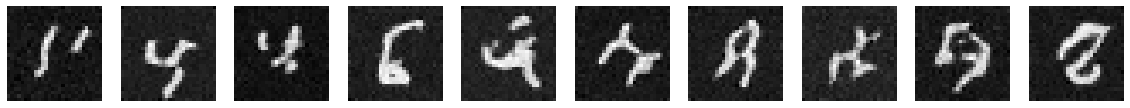

In [75]:
plt.figure(figsize=(20, 8))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(xT[i][0].cpu(), cmap='gray')
    plt.axis(False)